# Tool Criticism in Digital Humanities Research

## TF\*IDF for Social Media Texts

This notebook provides some insights in how TF\*IDF works and points to some potential pitfalls and things to take into account, to develop intuitions for when and how to use it, and what questions to ask yourself when incorporating it in your research processes.

We look at in two types of social media texts:

- **Amazon book reviews**: Two sets of 10,000 reviews each (taken from the excellent [Amazon Review Data](https://nijianmo.github.io/amazon/index.html) site). We are interested in comparing sets of books reviews to get insight into how books affect readers and how, for instance, the introduction of a TV or Film adaptation influences this.

- **Tweets**: a rather arbitrary set of very old tweets, taken from a much larger [collection of tweets available on Kaggle](https://www.kaggle.com/kazanova/sentiment140).

We start with a set of user reviews of the book *The Handmaid's Tale* by Margaret Atwood. The dataset consists of 10,000 Amazon user reviews. 

*Note*: The code below is not how you would normally use TF\*IDF. The [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is one of several libraries that have great code for this. But the simple code here makes transparent what transformation steps are taken and **thereby makes it easy to look under the hood**.

### Question 1

These round numbers of reviews should trigger alarm bells that this is probably a selection from a larger set reviews, but is capped at 10,000 for convenience. What do you need to know about the selection process to understand what this dataset represents and what its limitations are?

In [1]:
# In case you haven't installed the modules below yet, uncomment and run the following line
#!pip install pandas requests nltk

import pandas as pd
import requests
import nltk

You need to run the cell below only once to download the data.

In [2]:
datasets = [
    {
        'name': 'handmaid_reviews',
        'file': 'reviews-amazon-handmaids_tale.csv.gz', 
        'url': 'https://surfdrive.surf.nl/files/index.php/s/HQYhNS151OCcfco/download'
    },
    {
        'name': 'mixed_reviews',
        'file': 'reviews-amazon-100-books.csv.gz', 
        'url': 'https://surfdrive.surf.nl/files/index.php/s/V0R0E1lMRueVVkG/download'
    },
    {
        'name': 'kaggle-tweets',
        'file': 'kaggle_tweets-april.csv.gz', 
        'url': 'https://surfdrive.surf.nl/files/index.php/s/ne5Vmskf8f9yP6f/download'
    },
]

def download_datasets():
    for dataset in datasets:
        response = requests.get(dataset['url'])
        with open(dataset['file'], 'wb') as fh:
            fh.write(response.content)

download_datasets()

In [3]:
handmaid_reviews_file = 'reviews-amazon-handmaids_tale.csv.gz'

df = pd.read_csv(handmaid_reviews_file, compression='gzip', parse_dates=[3])
df.head(5)

,asin,reviewer_name,vote,review_time,overall,reviewer_id,title,style,category,num_chars,review_lang,image,book_id,verified,review_text,summary,unixReviewTime,review_id
0,99740915,Amazon Customer,2,1996-12-25,5.0,AJVVATHEYX7L9,The Handmaid's Tale (Contemporary Classics),{'Format:': ' Paperback'},"['Books', 'Literature & Fiction', 'Contemporary']",701,en,NaN,99740915,False,I didn't know what to expect when I decided to...,The things that stick with you...,851472000,0099740915-AJVVATHEYX7L9
1,99740915,Jim,NaN,2018-05-02,4.0,A2O537TL23PMQF,The Handmaid's Tale (Contemporary Classics),{'Format:': ' Kindle Edition'},"['Books', 'Literature & Fiction', 'Contemporary']",107,en,NaN,99740915,False,Loved it! A well written novel can transport m...,Impressive,1525219200,0099740915-A2O537TL23PMQF
2,99740915,B. Wilfong,NaN,2018-05-02,4.0,A2ZATPER188K3J,The Handmaid's Tale (Contemporary Classics),{'Format:': ' Paperback'},"['Books', 'Literature & Fiction', 'Contemporary']",2067,en,NaN,99740915,False,"Obviously, The Handmaids Tale has been on my r...",Its lack of love we die from.,1525219200,0099740915-A2ZATPER188K3J
3,99740915,Vickie Woodard,NaN,2018-05-02,5.0,A196VEITY4SDJZ,The Handmaid's Tale (Contemporary Classics),{'Format:': ' Kindle Edition'},"['Books', 'Literature & Fiction', 'Contemporary']",345,en,NaN,99740915,False,It's inconceivable to me as an American that r...,",SCARY",1525219200,0099740915-A196VEITY4SDJZ
4,99740915,Corinne Bazella,NaN,2018-05-01,5.0,A1CQDKX2O0GVSY,The Handmaid's Tale (Contemporary Classics),{'Format:': ' Kindle Edition'},"['Books', 'Literature & Fiction', 'Contemporary']",149,en,NaN,99740915,False,Difficult to read in the times we are living i...,Scary,1525132800,0099740915-A1CQDKX2O0GVSY


In [4]:
print('Date first review:', df.review_time.min())
print('Date last review:', df.review_time.max())


Date first review: 1996-12-25 00:00:00
Date last review: 2018-05-02 00:00:00


There are some reviews that have no text, only a rating. Since we're interested in textual analysis, we drop the non-text reviews, but we should also check how many there are, to know how much we loose.

In [5]:
df.review_text.isna().value_counts()


False    9992
True        8
Name: review_text, dtype: int64

Only 8 reviews have no text, so dropping them has a negligible impact.

In [6]:
df = df[df.review_text.isna() == False]

Plot a histogram of the review dates:

<AxesSubplot:>

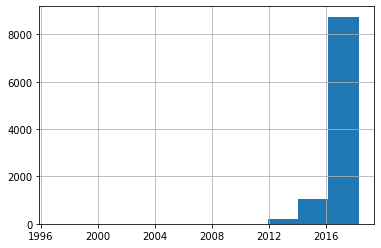

In [7]:
df.review_time.hist()


The vast majority of reviews were written after 2016. 

The TV series of The Handmaid's Tale was first released on April 26, 2017, so probably, the popularity of the series has increased the popularity of the book. But there are also many reviews written before the release of the series, so this dataset might be able to shed light on how the TV series influences readers' perception of the book.




In [8]:
# The hype was building up well before the series first aired, 
# so let's see the dividing date to the first of January 2017
series_start = pd.to_datetime('2017-01-01')
df['pre_release'] = df.review_time.apply(lambda x: x < series_start)


Another thing to look at is review length, which varies strongly from just one or two words, to thousands of words. Below you can see the distribution of review lengths in number of characters. The majority of reviews are very short.

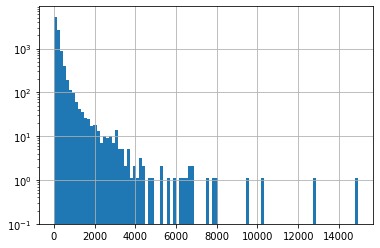

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df.num_chars.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')


### Text Analysis: Term Frequency, Document Frequency and TF\*IDF

We will start with a sample of 100 reviews for efficiency, to get a feel for issues you run in to. We iterate over the reviews to compute term frequencies. No surprisingly, the most frequent words are stopwords. 

In [10]:
sample_reviews = list(df.review_text)[:100]

In [11]:
from collections import Counter
import re

# create a frequency counter for terms
tf = Counter()

# iterater o
for review in sample_reviews:
    words = [word.lower() for word in re.split(r'\W+', review) if word != '']
    tf.update(words)

for word, freq in tf.most_common(20):
    print(f'{word: <20}{freq: >5}')


the                   315
i                     169
a                     137
it                    129
to                    126
and                   117
of                    115
book                   94
was                    87
this                   75
is                     69
in                     61
that                   59
read                   58
but                    42
t                      37
have                   35
not                    31
for                    30
with                   29


Lists of stopwords for English are common, although there are big differences. Some contain around 80-100 words, others contain 500-600 words. 

### Question 2

How do you chose which stopword list to use? And what is the difference between *using* long and short lists?

In [12]:
def read_stopwords():
    stopwords_url = 'https://surfdrive.surf.nl/files/index.php/s/UoD4z6KNFKfwPbA/download'
    response = requests.get(stopwords_url)
    return response.text.split('\n')
    
stopwords = read_stopwords()

doc_freq = Counter()

for review in sample_reviews:
    words = [word.lower() for word in re.split(r'\W+', review) if word != '' and word.lower() not in stopwords]
    doc_freq.update(set(words))

for word, freq in doc_freq.most_common(20):
    print(f'{word: <30}{freq: >5}')


book                             59
read                             43
story                            24
series                           21
time                             17
would                            16
like                             14
could                            14
well                             13
recommend                        12
made                             11
written                          11
much                             11
first                            11
great                            11
hulu                             11
future                           10
lot                              10
dystopian                        10
left                             10


## Domain stopwords

Beyond generic stopwords, each domain has its own common stopwords. Within the book review domain, words such as 'book', 'read', 'story' and 'like' are not very insightful, as well as common verbs that are not in the stopword list. 

### Question 3:

Would it be sensible to add domain-specific stopwords to the stopword list? What potential problems could it cause? What benefits could it have?

## Inverted document frequency

Below, we compute per word/term what it's inverted document frequency is using the formula:

$idf_i = log(\frac{N}{df_i}) + 1$

Where $N$ is the total number of texts we're using (100 in the case of the sample, but we'll use all 10,000 soon).



In [13]:
import math

# create the IDF index
idf = {}
# we need the total number of reviews in the sample
num_docs = len(sample_reviews)

for word in doc_freq:
    # per word, divide the number of reviews by the number of reviews containing the word
    # the logarithm compresses this fraction
    idf[word] = math.log(num_docs / doc_freq[word]) + 1



Below, we look at a single review and the tf, df, idf and tf\*idf scores for the words in it:

In [14]:
import math


def text_to_tf(text, stopwords):
    """Simple function to turn review text into list of lowercase words without stopwords"""
    words = [word.lower() for word in re.split(r'\W+', text) if word != '' and word.lower() not in stopwords]
    return Counter(words)

def make_doc_tfidf_df(text, doc_freq, idf, stopwords):
    """Turn a single review text into a Pandas dataframe with tf, df, idf and tf*idf info."""
    term_freq = text_to_tf(text, stopwords)
    terms = list(term_freq.keys())
    return pd.DataFrame({
        'term': terms,
        'tf': [term_freq[term] for term in terms],
        'df': [doc_freq[term] for term in terms],
        'idf': [idf[term] for term in terms],
        'tf.idf': [term_freq[term] * idf[term] for term in terms],
    })

stopwords_en = read_stopwords()

print('Review text:\n\n', sample_reviews[2])

tfidf_doc = make_doc_tfidf_df(sample_reviews[2], doc_freq, idf, stopwords)
tfidf_doc.head(10)


Review text:

 Obviously, The Handmaids Tale has been on my radar for a long time. Now I have read it. Talking to a friend about it yesterday we kept saying the same thing, it fell a little flat for us.
The premise is intriguing yet ridiculous, but of course you have to suspend your disbelief anytime you pick up a dystopian novel. However, I did not have to suspend my disbelief this much reading Fahrenheit 451. Or maybe I did, and it just did not feel as obvious to me? The book reads as the written notes of a woman (we know her as Offred-not her real name) about her experiences as a Handmaid in the Republic of Gilead (somewhere in the northeast of the former United States).
What is supremely interesting in the text is how many gaps Margaret Atwood leaves for the reader to fill. That is one of the more powerful elements of the novel.  I feel that those who read this book and come away with a political or gender issue message miss the forest for the trees. In her Forward to the 2017 edit

,term,tf,df,idf,tf.idf
0,obviously,1,1,5.605170,5.605170
1,handmaids,2,4,4.218876,8.437752
2,tale,2,9,3.407946,6.815891
3,radar,1,2,4.912023,4.912023
4,long,1,6,3.813411,3.813411
5,time,1,17,2.771957,2.771957
6,read,3,43,1.843970,5.531910
7,talking,1,1,5.605170,5.605170
8,friend,1,1,5.605170,5.605170
9,yesterday,1,1,5.605170,5.605170


## Ranking words by TF, IDF and TF\*IDF

For the same review, we now rank the words by their term frequency:

In [15]:
# First, we rank the words in the review by term frequency
tfidf_doc.sort_values('tf', ascending=False).head(10)


,term,tf,df,idf,tf.idf
64,one,6,7,3.659260,21.955560
36,book,5,59,1.527633,7.638164
6,read,3,43,1.843970,5.531910
27,novel,3,9,3.407946,10.223837
56,text,3,2,4.912023,14.736069
34,feel,3,5,3.995732,11.987197
81,story,3,24,2.427116,7.281349
37,reads,2,1,5.605170,11.210340
39,notes,2,2,4.912023,9.824046
65,powerful,2,2,4.912023,9.824046


In [16]:
# Next, we rank by IDF (thus ignoring the frequency of each word in the review)
tfidf_doc.sort_values('idf', ascending=False).head(10)


,term,tf,df,idf,tf.idf
0,obviously,1,1,5.60517,5.60517
80,hint,1,1,5.60517,5.60517
96,themes,1,1,5.60517,5.60517
95,storys,1,1,5.60517,5.60517
94,application,1,1,5.60517,5.60517
93,universal,1,1,5.60517,5.60517
90,filter,1,1,5.60517,5.60517
89,brings,1,1,5.60517,5.60517
88,issues,1,1,5.60517,5.60517
86,appreciating,1,1,5.60517,5.60517


In [17]:
# Finally, we rank by a combination of term frequency and inverted document frequency
tfidf_doc.sort_values('tf.idf', ascending=False).head(10)

,term,tf,df,idf,tf.idf
64,one,6,7,3.659260,21.955560
56,text,3,2,4.912023,14.736069
34,feel,3,5,3.995732,11.987197
37,reads,2,1,5.605170,11.210340
63,fill,2,1,5.605170,11.210340
23,disbelief,2,1,5.605170,11.210340
22,suspend,2,1,5.605170,11.210340
27,novel,3,9,3.407946,10.223837
65,powerful,2,2,4.912023,9.824046
39,notes,2,2,4.912023,9.824046


Words like 'disbelief' and 'suspend' are much less common in these reviews than words like 'one' and 'feel', therefore, their IDF is higher. But note that 'feel' occurs three times in this review, so its $tf \cdot idf$ score is higher than that of 'disbelief'.

### Question 4

What is the impact of the logarithm in the IDF formula? What does it do to the difference between words with a low IDF and words with a high IDF?

## TF\*IDF and Number of Texts

Now we scale up to the full set of 10,000 reviews to see how the size of the collection affects scores.

We look at the same review again to see how a larger corpus of reviews affects TF\*IDF scores.

In [18]:
doc_freq_all = Counter()

for review in df.review_text:
    words = [word.lower() for word in re.split(r'\W+', review) if word != '' and word.lower() not in stopwords]
    doc_freq_all.update(set(words))

# create the IDF index
idf_all = {}
# we need the total number of reviews in the sample
num_docs = len(df.review_text)

for word in doc_freq_all:
    # per word, divide the number of reviews by the number of reviews containing the word
    # the logarithm compresses this fraction
    idf_all[word] = math.log(num_docs / doc_freq_all[word]) + 1


# Show the scores for the same sample review
tfidf_doc_all = make_doc_tfidf_df(sample_reviews[2], doc_freq_all, idf_all, stopwords)
tfidf_doc_all.head(10)


,term,tf,df,idf,tf.idf
0,obviously,1,26,6.951444,6.951444
1,handmaids,2,245,4.708282,9.416564
2,tale,2,919,3.386254,6.772508
3,radar,1,2,9.516393,9.516393
4,long,1,287,4.550058,4.550058
5,time,1,1146,3.165507,3.165507
6,read,3,3755,1.978696,5.936089
7,talking,1,37,6.598622,6.598622
8,friend,1,54,6.220556,6.220556
9,yesterday,1,10,7.906955,7.906955


Again, we rank the words in the sample review first by TF, then IDF, then TF\*IDF:

In [19]:
tfidf_doc_all.sort_values('tf', ascending=False).head(10)


,term,tf,df,idf,tf.idf
64,one,6,1139,3.171634,19.029805
36,book,5,4786,1.736090,8.680449
6,read,3,3755,1.978696,5.936089
27,novel,3,633,3.759070,11.277209
56,text,3,31,6.775553,20.326659
34,feel,3,367,4.304178,12.912535
81,story,3,2349,2.447795,7.343385
37,reads,2,65,6.035153,12.070306
39,notes,2,60,6.115195,12.230391
65,powerful,2,113,5.482152,10.964304


In [20]:
tfidf_doc_all.sort_values('idf', ascending=False).head(10)


,term,tf,df,idf,tf.idf
100,foist,1,1,10.209540,10.209540
111,fluidly,1,1,10.209540,10.209540
125,gap,1,1,10.209540,10.209540
90,filter,1,2,9.516393,9.516393
3,radar,1,2,9.516393,9.516393
94,application,1,2,9.516393,9.516393
50,northeast,1,2,9.516393,9.516393
118,didactic,1,2,9.516393,9.516393
54,supremely,1,3,9.110928,9.110928
93,universal,1,3,9.110928,9.110928


In [21]:
tfidf_doc_all.sort_values('tf.idf', ascending=False).head(10)


,term,tf,df,idf,tf.idf
56,text,3,31,6.775553,20.326659
64,one,6,1139,3.171634,19.029805
22,suspend,2,6,8.417781,16.835561
23,disbelief,2,14,7.570483,15.140965
63,fill,2,21,7.165018,14.330035
34,feel,3,367,4.304178,12.912535
39,notes,2,60,6.115195,12.230391
37,reads,2,65,6.035153,12.070306
27,novel,3,633,3.759070,11.277209
65,powerful,2,113,5.482152,10.964304


In the larger set of reviews, the word 'feel' is much more common than 'disbelief', so now its $idf$ and therefore its $tf \cdot idf$ scores are much lower. 

### Question 5

Why does the total number of documents matter in how important words are for a document, relative to each other?

## Document Heterogeneity

Does it matter how heterogeneous the corpus is?

In the next steps, a different set of 10,000 reviews is used, with the same first 100 reviews of *The Handmaid's Tale*, but now mixed with 100 reviews each for 99 other books. 

In [22]:
import pandas as pd
mixed_review_file = 'reviews-amazon-100-books.csv.gz'

df = pd.read_csv(mixed_review_file, compression='gzip', parse_dates=[3])
df.head(5)

,asin,reviewer_name,num_chars,review_time,overall,reviewer_id,title,style,category,review_lang,vote,image,book_id,verified,review_text,summary,unixReviewTime,review_id
0,038568231X,Marti Hummel,3,2015-07-09,2.0,A2HZ7R8HLEYSCC,The Girl on the Train,{'Format:': ' Kindle Edition'},"['Books', 'Mystery, Thriller & Suspense', 'Mys...",en,NaN,NaN,038568231X,True,Not,Two Stars,1436400000,038568231X-A2HZ7R8HLEYSCC
1,038568231X,Robert Ressler,253,2015-07-09,5.0,A88LMY9VHX5RC,The Girl on the Train,{'Format:': ' Kindle Edition'},"['Books', 'Mystery, Thriller & Suspense', 'Mys...",en,NaN,NaN,038568231X,True,Outstanding writing as the story builds from t...,get on the train!,1436400000,038568231X-A88LMY9VHX5RC
2,038568231X,Lee,34,2015-07-09,4.0,A3W5789XEHUVPC,The Girl on the Train,{'Format:': ' Kindle Edition'},"['Books', 'Mystery, Thriller & Suspense', 'Mys...",en,NaN,NaN,038568231X,True,Very well written keeps u guessing,Four Stars,1436400000,038568231X-A3W5789XEHUVPC
3,038568231X,Tom,10,2015-07-09,4.0,A1QE4E7S9MLTPC,The Girl on the Train,{'Format:': ' Kindle Edition'},"['Books', 'Mystery, Thriller & Suspense', 'Mys...",en,NaN,NaN,038568231X,True,Great book,Four Stars,1436400000,038568231X-A1QE4E7S9MLTPC
4,038568231X,Myra C,285,2015-07-09,3.0,A1PBOFGY8NAKNQ,The Girl on the Train,{'Format:': ' Kindle Edition'},"['Books', 'Mystery, Thriller & Suspense', 'Mys...",en,NaN,NaN,038568231X,True,"It was a good read, but I swear the author got...",Very familiar Story,1436400000,038568231X-A1PBOFGY8NAKNQ


In [23]:
df.title.value_counts()

Oliver Twist (Penguin Clothbound Classics)                                       100
The Dead Key                                                                     100
Harry Potter (4 Volumes set)                                                     100
Inferno                                                                          100
22/11/63                                                                         100
                                                                                ... 
Maze Runner. Correr o Morir / Maze Runner, Run or die (Spanish Edition)          100
The Girl on the Train                                                            100
Grey: Fifty Shades of Grey as Told by Christian (Fifty Shades of Grey Series)    100
Killing Jesus (Bill O'Reilly's Killing Series)                                   100
Thirteen Reasons Why                                                             100
Name: title, Length: 100, dtype: int64

Again, we look at the same sample review to see the impact of heterogeneity of the corpus.

In [24]:
doc_freq_all = Counter()

for review in df.review_text:
    words = [word.lower() for word in re.split(r'\W+', review) if word != '' and word.lower() not in stopwords]
    doc_freq_all.update(set(words))

# create the IDF index
idf_all = {}
# we need the total number of reviews in the sample
num_docs = len(df.review_text)

for word in doc_freq_all:
    # per word, divide the number of reviews by the number of reviews containing the word
    # the logarithm compresses this fraction
    idf_all[word] = math.log(num_docs / doc_freq_all[word]) + 1

tfidf_doc_mixed = make_doc_tfidf_df(sample_reviews[2], doc_freq_all, idf_all, stopwords)
tfidf_doc_mixed.head(10)


,term,tf,df,idf,tf.idf
0,obviously,1,36,6.626821,6.626821
1,handmaids,2,4,8.824046,17.648092
2,tale,2,144,5.240527,10.481054
3,radar,1,3,9.111728,9.111728
4,long,1,403,4.211404,4.211404
5,time,1,1138,3.173313,3.173313
6,read,3,3638,2.011151,6.033453
7,talking,1,46,6.381699,6.381699
8,friend,1,133,5.319991,5.319991
9,yesterday,1,10,7.907755,7.907755


And again, we rank the words in the sample review by IDF and TF\*IDF:

In [25]:
tfidf_doc_mixed.sort_values('idf', ascending=False).head(10)


,term,tf,df,idf,tf.idf
32,451,1,1,10.210340,10.210340
31,fahrenheit,1,1,10.210340,10.210340
111,fluidly,1,1,10.210340,10.210340
50,northeast,1,1,10.210340,10.210340
75,trees,1,2,9.517193,9.517193
118,didactic,1,2,9.517193,9.517193
95,storys,1,2,9.517193,9.517193
115,trap,1,2,9.517193,9.517193
94,application,1,2,9.517193,9.517193
48,gilead,1,2,9.517193,9.517193


In [26]:
tfidf_doc_mixed.sort_values('tf.idf', ascending=False).head(10)

,term,tf,df,idf,tf.idf
56,text,3,49,6.318520,18.955560
42,offred,2,4,8.824046,17.648092
1,handmaids,2,4,8.824046,17.648092
64,one,6,1640,2.807889,16.847333
22,suspend,2,7,8.264430,16.528860
60,atwood,2,8,8.130899,16.261798
23,disbelief,2,14,7.571283,15.142566
63,fill,2,22,7.119298,14.238596
39,notes,2,32,6.744604,13.489209
26,dystopian,2,49,6.318520,12.637040


### Question 6

How does the heterogeneity of the collection affect the TF\*IDF scores and ranking of terms in a document?


## TF\*IDF and Tweets

Finally, we compute TF\*IDF for a set of tweets and look at its impact on the importance of terms.

First, we read the tweets into a Pandas data frame.

In [27]:
tweet_file = 'kaggle_tweets-april.csv.gz'
df = pd.read_csv(tweet_file, compression='gzip', parse_dates=[3])
df.head(5)



,sentiment_score,tweet_id,timestamp,flag,username,text,date
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06


Next, we calculate the DF and IDF dictionaries and show the TF, IDF and TF\*IDF scores for a single tweet:

In [28]:
doc_freq_all = Counter()

for tweet_text in df.text:
    words = [word.lower() for word in re.split(r'\W+', tweet_text) if word != '' and word.lower() not in stopwords]
    doc_freq_all.update(set(words))

# create the IDF index
idf_all = {}
# we need the total number of reviews in the sample
num_docs = len(df.text)

for word in doc_freq_all:
    # per word, divide the number of reviews by the number of reviews containing the word
    # the logarithm compresses this fraction
    idf_all[word] = math.log(num_docs / doc_freq_all[word]) + 1

tweet_texts = list(df.text)
print('Tweet:\n\n', tweet_texts[2])

tfidf_doc_tweet = make_doc_tfidf_df(tweet_texts[2], doc_freq_all, idf_all, stopwords)
tfidf_doc_tweet.head(20)


Tweet:

 @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds


,term,tf,df,idf,tf.idf
0,kenichan,1,3,11.414563,11.414563
1,dived,1,1,12.513175,12.513175
2,many,1,583,6.144988,6.144988
3,times,1,438,6.430957,6.430957
4,ball,1,60,8.418831,8.418831
5,managed,1,64,8.354292,8.354292
6,save,1,134,7.615336,7.615336
7,50,1,103,7.878446,7.878446
8,rest,1,353,6.646707,6.646707
9,go,1,4380,4.128371,4.128371


In [29]:
tfidf_doc_tweet.sort_values('tf', ascending=False).head(20)

,term,tf,df,idf,tf.idf
0,kenichan,1,3,11.414563,11.414563
1,dived,1,1,12.513175,12.513175
2,many,1,583,6.144988,6.144988
3,times,1,438,6.430957,6.430957
4,ball,1,60,8.418831,8.418831
5,managed,1,64,8.354292,8.354292
6,save,1,134,7.615336,7.615336
7,50,1,103,7.878446,7.878446
8,rest,1,353,6.646707,6.646707
9,go,1,4380,4.128371,4.128371


In [30]:
tfidf_doc_tweet.sort_values('idf', ascending=False).head(20)

,term,tf,df,idf,tf.idf
1,dived,1,1,12.513175,12.513175
0,kenichan,1,3,11.414563,11.414563
10,bounds,1,3,11.414563,11.414563
4,ball,1,60,8.418831,8.418831
5,managed,1,64,8.354292,8.354292
7,50,1,103,7.878446,7.878446
6,save,1,134,7.615336,7.615336
8,rest,1,353,6.646707,6.646707
3,times,1,438,6.430957,6.430957
2,many,1,583,6.144988,6.144988


In [31]:
tfidf_doc_tweet.sort_values('tf.idf', ascending=False).head(20)

,term,tf,df,idf,tf.idf
1,dived,1,1,12.513175,12.513175
0,kenichan,1,3,11.414563,11.414563
10,bounds,1,3,11.414563,11.414563
4,ball,1,60,8.418831,8.418831
5,managed,1,64,8.354292,8.354292
7,50,1,103,7.878446,7.878446
6,save,1,134,7.615336,7.615336
8,rest,1,353,6.646707,6.646707
3,times,1,438,6.430957,6.430957
2,many,1,583,6.144988,6.144988


Now compare the IDF and TF\*IDF scores and rankings.

### Question 7

What does TF\*IDF measure in tweets? What is the impact of term frequency in tweets in TF\*IDF? And what is the impact of IDF?

## Further Investigation

### Topical Analysis Using TF\*IDF or Just TF

Below you can do topic extraction with Non-Negative Matrix Factorization ([NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF), which uses TF\*IDF) and with Latent Dirichlet Allocation ([LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation), which uses just TF). There are various parameters that influence the extracted topics, e.g.:

- what document frequency thresholds to use,
- how many terms (features) to use,
- how many topics to extract, and
- which stopwords to filter

The value of each decision depends on what you're trying to achieve and how you intend to use it. 

First some preparatory stuff:

In [32]:
# Example taken from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    """Plots extracted topics use top N words and their weights."""
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()




In [33]:
import pandas as pd
mixed_reviews_url = 'https://surfdrive.surf.nl/files/index.php/s/V0R0E1lMRueVVkG/download'

handmaid_reviews_file = 'reviews-amazon-handmaids_tale.csv.gz'
mixed_reviews_file = 'reviews-amazon-100-books.csv.gz'

handmaid_df = pd.read_csv(handmaid_reviews_file, compression='gzip', parse_dates=[3])
mixed_df = pd.read_csv(mixed_reviews_file, compression='gzip', parse_dates=[3])

# We use a few heuristics to filter out useless terms: common 
# English words, words occurring in only one document or in 
# at least 50% of the documents are removed.

# Number of reviews
n_samples = 10000
# Number of features (= top TF words)
n_features = 1000
# Number of topics
n_components = 10
# How many top words to show per topic
n_top_words = 20
# maximum fraction of documents in which a term may occur
max_df_frac = 0.5


print("Loading dataset...")
t0 = time()
# We start with the reviews from a mix of 100 books
data = list(mixed_df.review_text)
data_samples = data[:n_samples]

print("done in %0.3fs." % (time() - t0))



Loading dataset...
done in 0.002s.


Extracting tf-idf features for NMF...
done in 0.680s.


 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=10000 and n_features=1000...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


done in 2.626s.


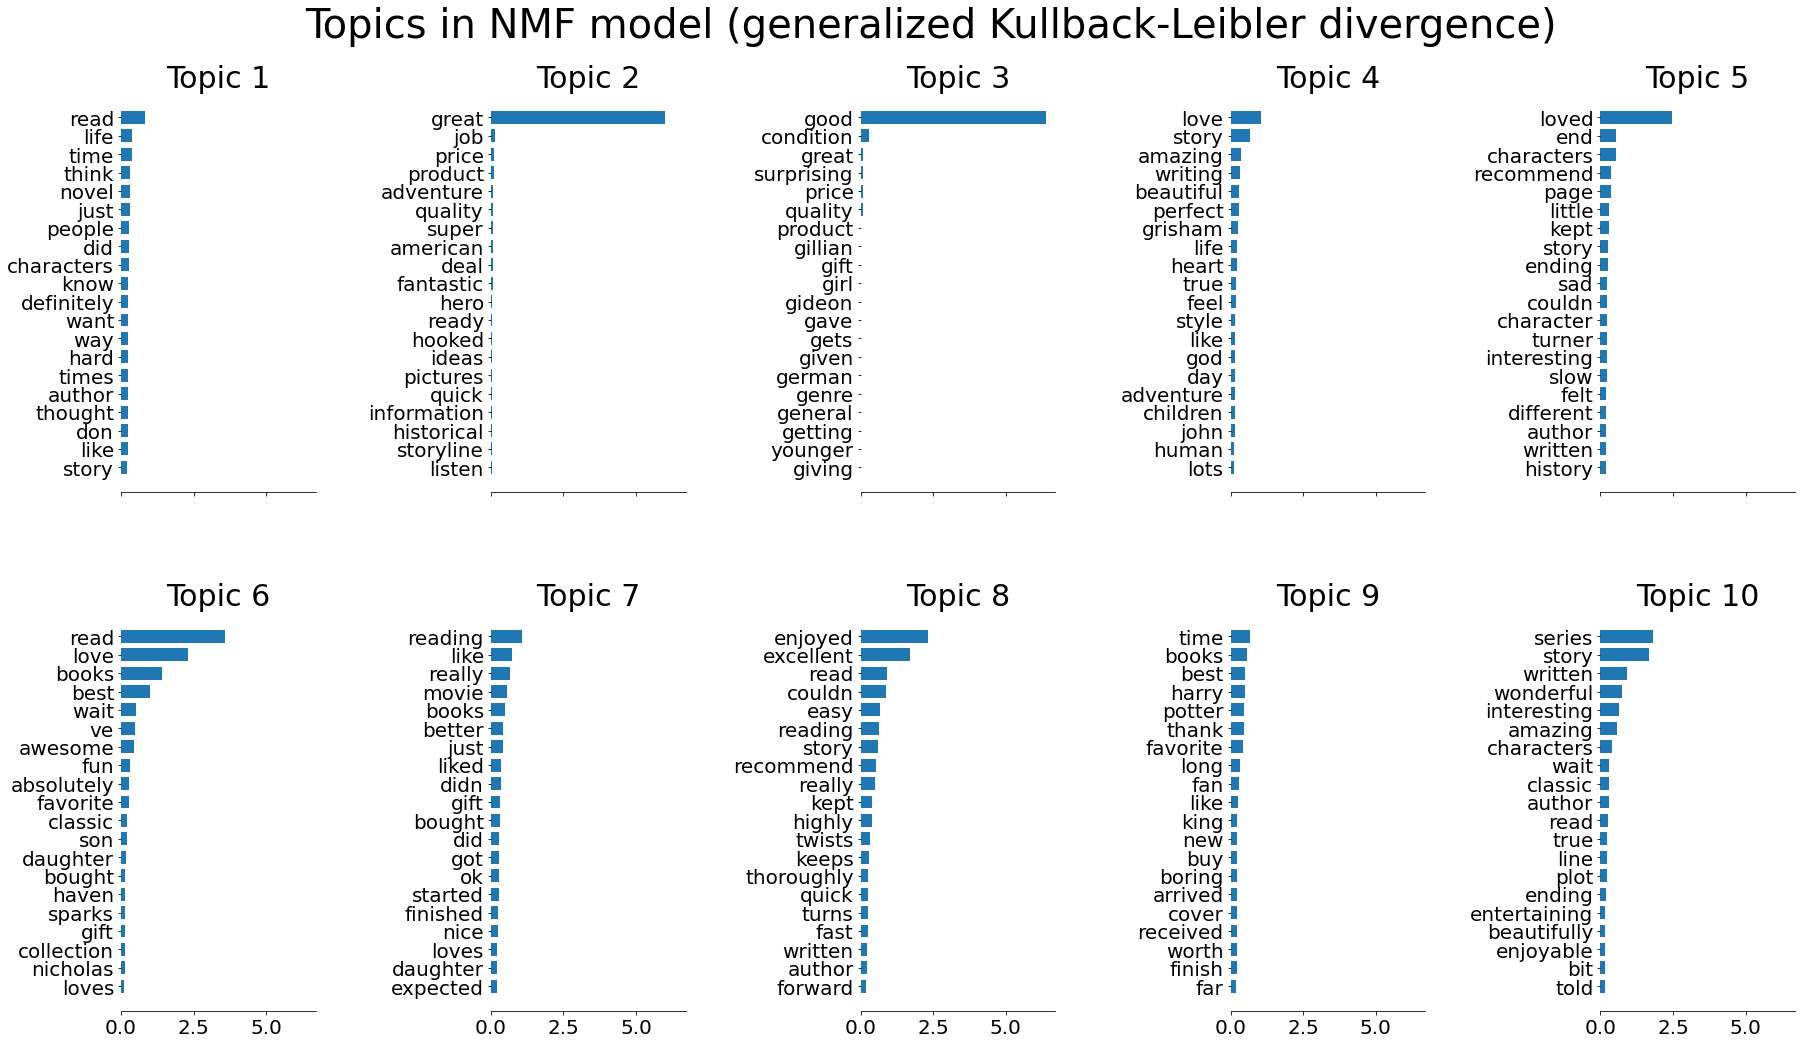

In [34]:
# Load the Amazon review datasets and vectorize it. 


###############################
# Use tf-idf features for NMF.#
###############################

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=max_df_frac, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')




Extracting tf features for LDA...
done in 0.624s.



 Fitting LDA models with tf features, n_samples=10000 and n_features=1000...
done in 11.890s.


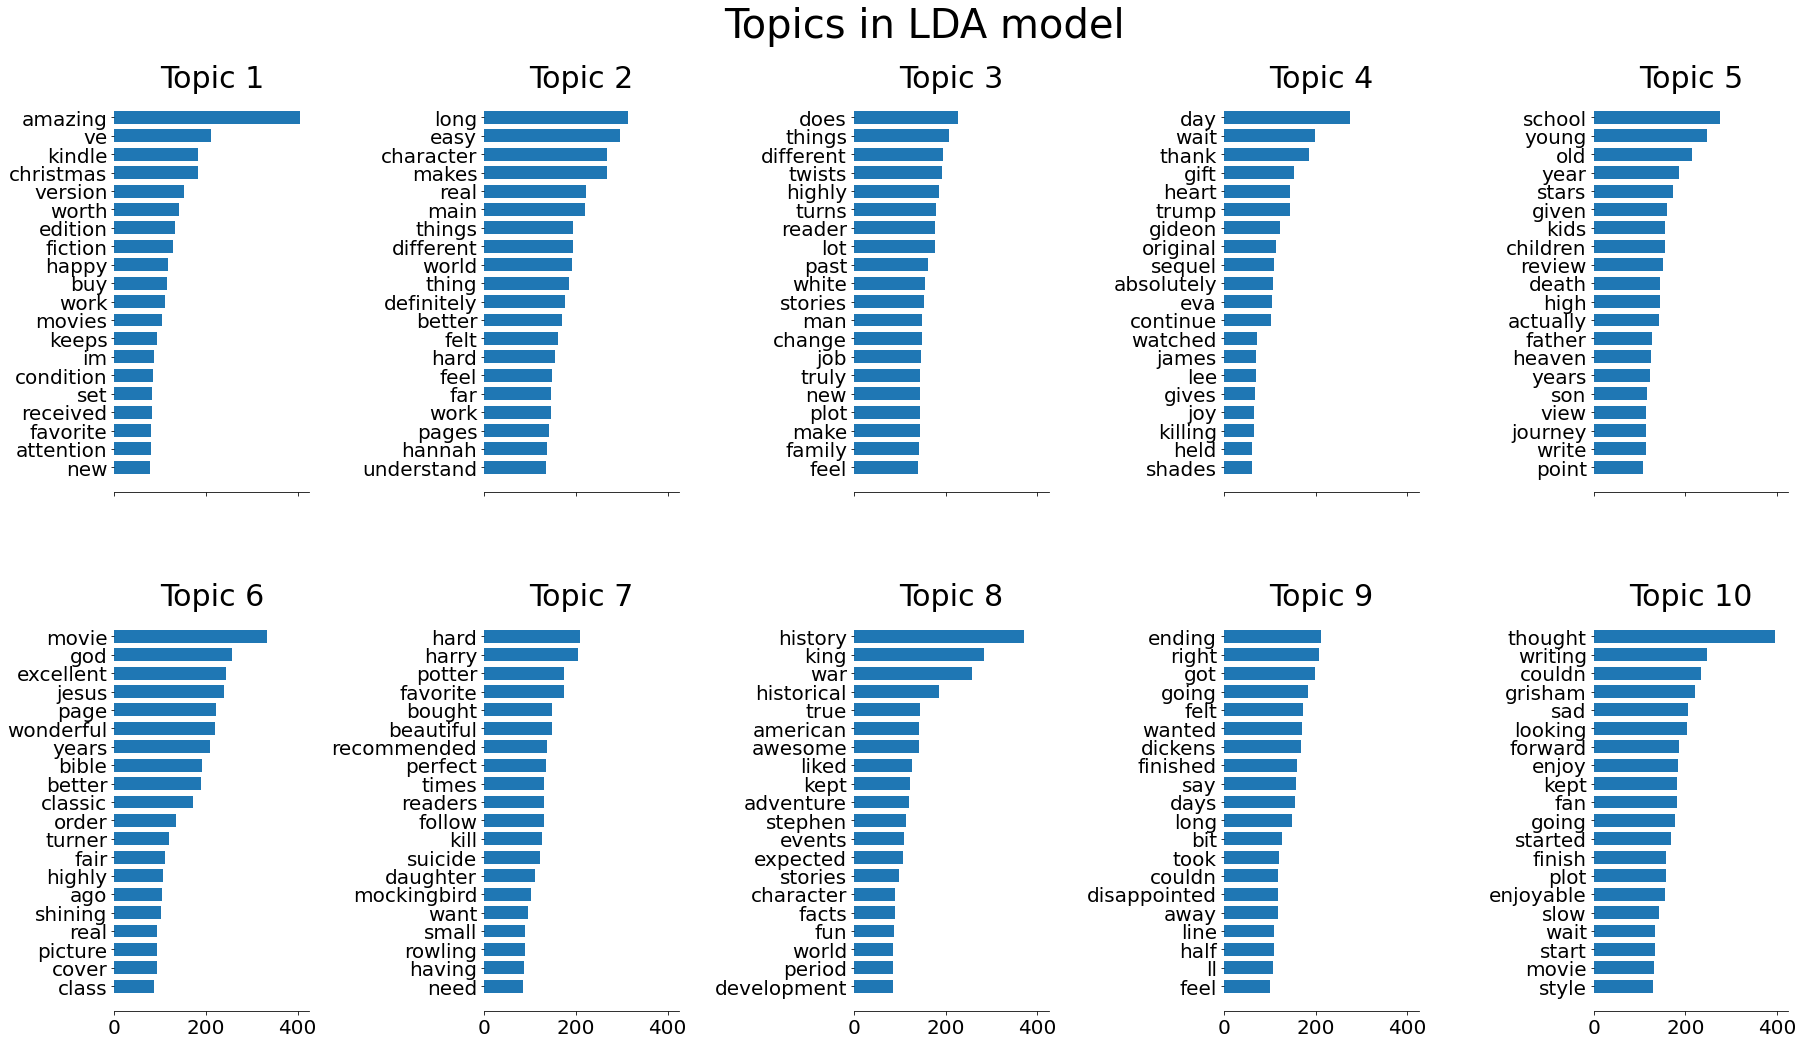

In [35]:
# Number of reviews
n_samples = 10000
# Number of features (= top TF words)
n_features = 1000
# Number of topics
n_components = 10
# How many top words to show per topic
n_top_words = 20
# maximum fraction of documents in which a term may occur
max_df_frac = 0.05


############################################
# Use tf (raw term count) features for LDA.#
############################################

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=max_df_frac, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')